# Genomic feature correlogram

- it uses bw insted of called peaks for epigenetic data

- therefore the data used is be the same as in pygenometracks visualization

- also split Ty1 and Ty3 because of  their apparent different role in centromere

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mcolors
from te_module.classes.bed import Bed
from te_module.classes.gff import Gff

In [2]:
window_size = 100_000
source_assembly = 'Lsyl'
bigwig_folder = 'data/bigwigs/100kb_windows'
fasta_file = 'data/assembly/' + source_assembly + '.fasta'
chr_sizes = 'data/chr_sizes/' + source_assembly + '_chr_sizes.tsv'
output_image = 'data/figures/colocalization_heatmap_100kb.svg'


In [3]:
'''
BigWig file for GC content
'''

bed = Bed()
output_path = bigwig_folder + '/GC.bw'
bed.gc_content_in_windows(chr_sizes, output_path, fasta_file, window_size)


Bigwig file created: data/bigwigs/100kb_windows/GC.bw
hi


In [4]:
'''
BigWig files for satellites and sat-free CENH3
'''
bed_paths = {}
bigwig_paths = {}

bed_paths['satellite-free_centromere'] = 'data/chip-seq/consensus_peaks/non_satellite_units.bed'
bed_paths['lusy1_functional'] = 'data/satellites/Lusy1_functional_fragments.bed'
bed_paths['lusy1_nonfunctional'] = 'data/satellites/Lusy1_nonfunctional_arrays.bed'
bed_paths['lusy2_functional'] = 'data/satellites/Lusy2_functional_fragments.bed'
bed_paths['lusy2_nonfunctional'] = 'data/satellites/Lusy2_nonfunctional_arrays.bed'

for feature in bed_paths:
    bed = Bed(bed_paths[feature])
    output_path = bigwig_folder + '/' + feature + '.bw'
    bed.bed_window_coverage_to_bigwig(window_size, chr_sizes, output_path)
    bigwig_paths[feature] = output_path

Bigwig file created: data/bigwigs/100kb_windows/satellite-free_centromere.bw
Bigwig file created: data/bigwigs/100kb_windows/lusy1_functional.bw
Bigwig file created: data/bigwigs/100kb_windows/lusy1_nonfunctional.bw
Bigwig file created: data/bigwigs/100kb_windows/lusy2_functional.bw
Bigwig file created: data/bigwigs/100kb_windows/lusy2_nonfunctional.bw


In [5]:

bigwig_paths['gc_content'] = bigwig_folder + '/GC.bw'

bigwig_paths['satellite-free_centromere'] = bigwig_folder + '/satellite-free_centromere.bw'
bigwig_paths['lusy1_functional'] = bigwig_folder + '/lusy1_functional.bw'
bigwig_paths['lusy1_nonfunctional'] = bigwig_folder + '/lusy1_nonfunctional.bw'
bigwig_paths['lusy2_functional'] = bigwig_folder + '/lusy2_functional.bw'
bigwig_paths['lusy2_nonfunctional'] = bigwig_folder + '/lusy2_nonfunctional.bw'

bigwig_paths['genes'] = bigwig_folder + '/genes.bw'
bigwig_paths['ty1_copia'] = bigwig_folder + '/Ty1.bw'
bigwig_paths['ty3_gypsy'] = bigwig_folder + '/Ty3.bw'
bigwig_paths['other_tes'] = bigwig_folder + '/transposons.bw'
bigwig_paths['H3K4'] = bigwig_folder + '/H3K4.bw'
bigwig_paths['H3K9'] = bigwig_folder + '/H3K9.bw'
bigwig_paths['CENH3'] = bigwig_folder + '/CenH3.bw'
bigwig_paths['CpG'] = bigwig_folder + '/CpG.bw'
bigwig_paths['CHH'] = bigwig_folder + '/CHH.bw'
bigwig_paths['CHG'] = bigwig_folder + '/CHG.bw'



In [6]:
joined_df = pd.DataFrame()

for name, bigwig_path in bigwig_paths.items():
    command = f'bigWigToWig {bigwig_path} tmp/{name}.wig'
    os.system(command)
    # read wig file into dataframe
    colnames = ['chr', 'start', 'end', name]
    df = pd.read_csv('tmp/' + name + '.wig', sep='\t', header=None, comment='#', names=colnames)
    # add df to joined_df
    if joined_df.empty:
        joined_df = df
    else:
        joined_df = joined_df.merge(df, on=['chr', 'start', 'end'], how='outer')
    # remove tmp files
    os.system('rm tmp/' + name + '.wig')

joined_df = joined_df.fillna(0)

# get rid of window identifiers
relevant_df = joined_df.drop(columns=['chr', 'start', 'end'])

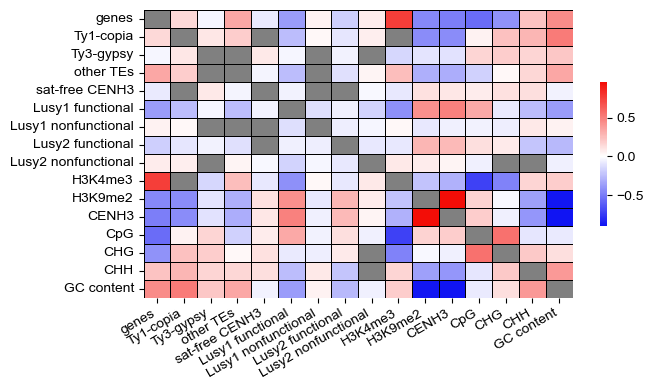

In [7]:
correlation_matrix = pd.DataFrame(index=relevant_df.columns, columns=relevant_df.columns)
p_value_matrix = pd.DataFrame(index=relevant_df.columns, columns=relevant_df.columns)
for feature1 in relevant_df.columns:
    for feature2 in relevant_df.columns:
        if feature1 != feature2:
            corr, p_value = spearmanr(relevant_df[feature1], relevant_df[feature2])
            correlation_matrix.loc[feature1, feature2] = corr
            p_value_matrix.loc[feature1, feature2] = p_value

subset = ['genes', 'ty1_copia', 'ty3_gypsy', 'other_tes', 'satellite-free_centromere', 'lusy1_functional', 'lusy1_nonfunctional', 'lusy2_functional', 'lusy2_nonfunctional', 'H3K4', 'H3K9', 'CENH3','CpG', 'CHG', 'CHH', 'gc_content']
subset_df= correlation_matrix[subset].loc[subset]
subset_df = subset_df.astype(float)
p_value_subset_df = p_value_matrix[subset].loc[subset]
p_value_subset_df = p_value_subset_df.fillna(1)
p_value_subset_df = p_value_subset_df.astype(float)
p_values = p_value_subset_df.values.flatten()
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]
adjusted_p_values = adjusted_p_values.reshape(p_value_subset_df.shape)
p_values_adjusted_df = pd.DataFrame(adjusted_p_values, index=subset, columns=subset)


mask = p_values_adjusted_df > 0.05


short_labels = ['genes', 'Ty1-copia', 'Ty3-gypsy', 'other TEs', 'sat-free CENH3', 'Lusy1 functional', 'Lusy1 nonfunctional', 'Lusy2 functional', 'Lusy2 nonfunctional', 'H3K4me3', 'H3K9me2','CENH3', 'CpG', 'CHG', 'CHH', 'GC content'] 


                
# correct p-values


# set the default font family to Arial
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# plot heatmap
plt.figure(figsize=(7,4))
colors = ['#0004f2ff', 'white','#f30600f8']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
cmap.set_bad("grey")
sns.heatmap(subset_df,mask=mask, cmap=cmap, center=0, 
            square=False, linewidths=.5,linecolor='black', cbar_kws={"shrink": .5})
plt.xticks(np.arange(len(short_labels))+0.5, short_labels, rotation=30, ha='right')
plt.yticks(np.arange(len(short_labels))+0.5, short_labels, rotation=0, va='center')
plt.tight_layout()
plt.savefig('data/figures/colocalization_heatmap.svg', dpi=300)
